# Practical 1: Keyword recognition for microcontrollers

**IMPORTANT**: Save a copy of this notebook in your Drive by clicking "_File->Save a copy in Drive_" and do the work using your copy.

Please attempt at least all non-optional questions in your chosen task set (A or B). Please submit a zip file of:


1. A text file with a publicly visible link to your notebook in Google Colab;
2. A downloaded copy (ipynb) of your notebook ("_File_->Download->Download (.ipynb)"). You may treat this as a report: we will not be re-executing the code you used to produce the answers, unless absolutely required.


If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

Usage: To train your neural networks using GPU acceleration, make sure that the runtime type is set to GPU in the _Runtime_->_Change runtime type_ menu. Further, you will see "cells" with code, which you can run either by using Ctrl+Enter or by clicking the play button in their top left corner. If you're not familiar with Google Colab or Jupyter Notebooks, you can check a tutorial video [here](https://www.youtube.com/watch?v=inN8seMm7UI):

[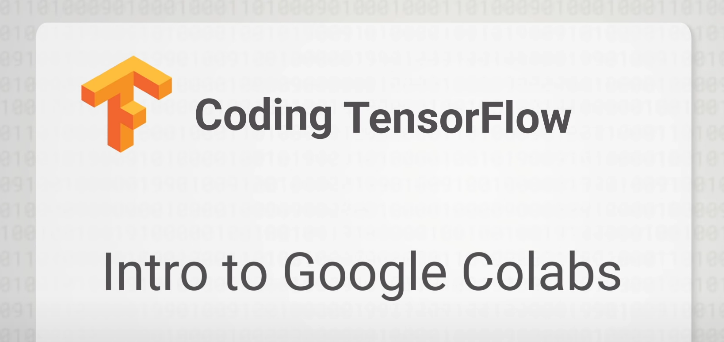](https://www.youtube.com/watch?v=inN8seMm7UI)

## Introduction

Small computational devices, such as microcontrollers, are often used in wearable, embedded or IoT devices where we need some but not too much computational ability, like a smart doorbell, a remote control, an Apple Pencil (!), to name a few. They are extremely power efficient, but also heavily resource-constrained: "high-end" microcontrollers will have up to 2 MB of storage, 1 MB of RAM and a ~400 MHz simple single-core ARM processor. Much worse than your average smartphone or a Raspberry Pi!

We can make devices powered by microcontroller units (MCUs) "smart" by running some very small neural networks on them. In this practical, we'll focus on keyword recognition, or spotting (KWS). That is, recognising spoken words, such as "Alexa" or "OK Google". Often in these systems, microcontroller-driven KWS is just the first step in the recognition pipeline. Once a light model, running on an MCU, spots what could be an activation word, it will enable better microphones, use a larger model and a more powerful processor to do the rest of the recognition.

Progression of the practical:
1. Training a model to recognise a keyword from a predefined set of keywords. This is done using convolutional networks trained on audio recordings that are converted to spectrograms.
2. Converting a TensorFlow/Keras model into the TFLite format, suitable for deployment on a constrained device. This will optimise the model (its computation graph) and quantise its parameters (more on that later).
3. Deploying your model onto a BBC micro:bit to see how it runs!

## Training a keyword spotting model

Let's set up the runtime. You can see the files being created by clicking the folder icon (Files sidebar) on the left hand side. The first 2 cells will take a while to run (setting up TensorFlow, downloading the dataset), so start them early. If you get disconnected from the machine, you will have to re-run these cells.

In [8]:
# Only need to run this cell once per machine you get allocated (i.e. when your files get lost).
# No need to re-run between different runtime refreshes.
# !pip uninstall -y tensorflow tensorflow-gpu tensorflow-estimator tensorboard keras
# !pip install tensorflow-gpu==2.7.0
!curl https://raw.githubusercontent.com/eliberis/microbit-speech/main/speech_dataset.py > speech_dataset.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 23632  100 23632    0     0  97276      0 --:--:-- --:--:-- --:--:-- 98466


We will use the [Speech Commands](https://arxiv.org/abs/1804.03209) dataset which contains thousands of audio recordings of short words, such as "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", etc. (see the linked paper for the full list, or open the "speech_dataset" folder in the Files sidebar once it has finished downloading).   Please note: this cell downloads the Speech Commands dataset, which might take up to 10 mins depending on your network conditions.

In [9]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

from speech_dataset import SpeechDataset
dataset = SpeechDataset(words=["yes", "no"],
                        upper_band_limit=5000.0,  # ~ human voice range
                        lower_band_limit=125.0,
                        feature_bin_count=25,
                        window_size_ms=40.0,
                        window_stride=20.0,
                        silence_percentage=3, unknown_percentage=3)
batch_size = 128
train_data = dataset.training_dataset().batch(batch_size).prefetch(1) # .prefetch(1) preloads a batch onto a GPU
valid_data = dataset.validation_dataset().batch(batch_size).prefetch(1)

Using TensorFlow version 2.12.0


OSError: [Errno 30] Read-only file system: '/content'

In the code above, we create a dataset with words "yes" and "no". The system will also add samples for 2 more classes, "*silence*" and "*unknown*", which will help the model to learn to better pick out target words from the noise. The amount of extra samples can be controlled with `silence_percentage=` and `unknown_percentage=` parameters (e.g. `silence_percentage=50`) to `SpeechDataset`.

Let's take a look at an example input:

In [ ]:
import IPython.display as ipd
ipd.Audio('speech_dataset/no/012c8314_nohash_0.wav')

The `SpeechDataset` class converts audio files into [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) inputs. Spectrograms can be treated as 2D images (frequency power vs time plot), which means we can use a convolutional neural network (CNN) for this classification problem. To see what the data looks like, let's visualise a few input spectrograms and labels (different every time you run!):

Word: yes


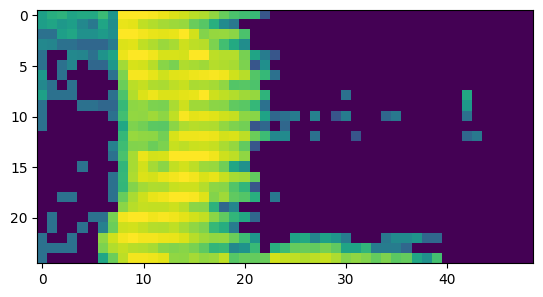

Word: no


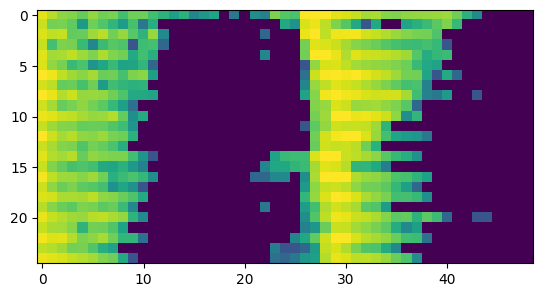

Word: no


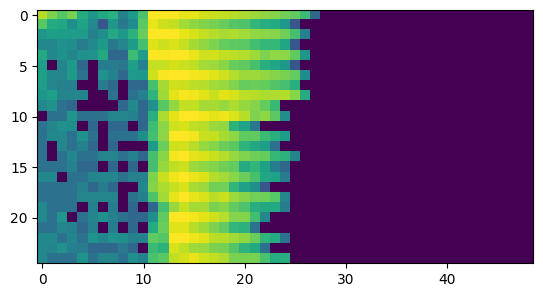

Word: yes


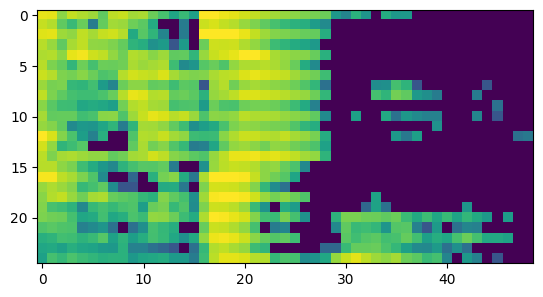

Word: yes


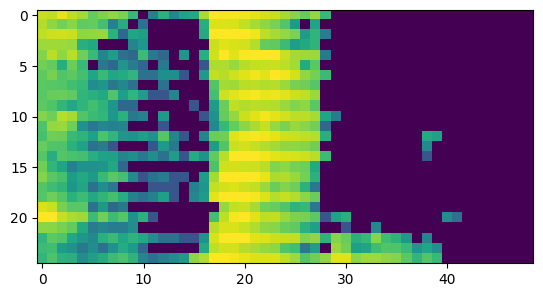

In [ ]:
import matplotlib.pyplot as plt
for spectrogram, label in dataset.testing_dataset().shuffle(50).take(5):
    spectrogram, label = spectrogram.numpy(), label.numpy()  # convert from Tensors to ndarrays
    print("Word:", dataset.look_up_word(label))
    plt.imshow(spectrogram[:, :, 0].T / 26.0, vmin=0.0, vmax=1.0)  # normalise back to 0.0 to 1.0
    plt.show()

Now, we set up and train a small model using the [Keras API](https://keras.io/guides/).

In [ ]:
import tensorflow as tf

input_shape = dataset.sample_shape()
num_classes = dataset.label_count()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (10, 8), strides=(2, 2), padding="SAME", activation="relu", input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation("softmax")
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_data, validation_data=valid_data, epochs=8)  # you'd want to train for more epochs!

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 25, 13, 16)        1296      
                                                                 
 flatten_3 (Flatten)         (None, 5200)              0         
                                                                 
 dropout_3 (Dropout)         (None, 5200)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 20804     
                                                                 
 activation_9 (Activation)   (None, 4)                 0         
                                                                 
Total params: 22100 (86.33 KB)
Trainable params: 22100 (86.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
53/53 [=

Training can take a while, depending on the complexity of your model and the number of epochs. Now let's check its performance on the test dataset and save the trained model.


In [ ]:
test_data = dataset.testing_dataset().batch(64)
model.evaluate(test_data)
model.save("model.h5")

14/14 [==============================] - 0s 20ms/step - loss: 0.2176 - accuracy: 0.9279


Download `model.h5` to your computer. From now on, if you lose connection to the runtime, you can resume work by uploading `model.h5` and using `model = tf.keras.models.load_model("model.h5")` to load the model instead of running the cell that trains the model from scratch.

### Testing with a custom recording

We can also test the model with a custom recording. The following will read the audio file and extract a spectrogram in a compatible way with the model (using the same parameters as the dataset preprocessing). Feel free to upload your own recordings in WAV format in the _Files_ sidebar!

In [ ]:
!curl https://raw.githubusercontent.com/eliberis/microbit-speech/main/yes.wav > yes.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64044  100 64044    0     0   230k      0 --:--:-- --:--:-- --:--:--  230k


In [ ]:
import IPython.display as ipd
ipd.Audio('yes.wav')

In [ ]:
# You can look up the sample rate in your file's metadata
# using a media player (defaults to 16000). If your recording
# is not in the right file format, convert it to 16-bit PCM WAV first.
sample = dataset.load_sample("yes.wav", sample_rate=16000).numpy()
print("Loaded file shape is", sample.shape, "and the model expects", dataset.sample_shape())

Loaded file shape is (99, 25, 1) and the model expects (49, 25, 1)


Due to different recording lengths, the first dimension of your sample might have a different length to what the model expects. In real-life, we would apply the model in a sliding window fashion until it goes over the segment of the audio where the keyword is audible. For now, however, we'll manually cut out a section of the audio of the expected length. For this, let's look at the spectogram of the entire recording:

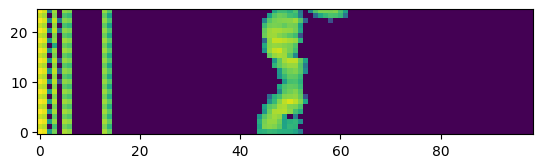

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(sample[:, :, 0].T, origin="lower")

We could start at `x=35` to capture the interesting portion of the audio:

In [ ]:
import numpy as np
import tensorflow as tf
start_pos = 35
end_pos = start_pos + dataset.sample_shape()[0] # (Height, Width, Channel)
predictions = model.predict(np.expand_dims(sample[start_pos:end_pos], axis=0))
print(predictions)
print("Predicted class:", dataset.look_up_word(predictions.argmax()))

1/1 [==============================] - 0s 111ms/step
[[5.9740506e-07 1.0933580e-03 9.9868566e-01 2.2033791e-04]]
Predicted class: yes


## Converting the model for MCU deployment

You've been provided with a BBC micro:bit! BBC micro:bit is a microcontroller-powered educational board, with many useful peripherals, which allow it to be used in lots of cool home projects.

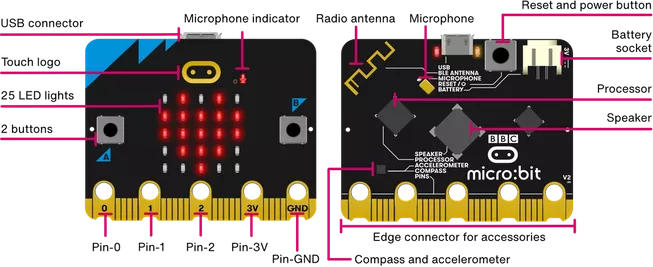


We need to take a few extra steps to ensure our model is compatible with the microcontroller environment.

### Model constraints and quantisation

We will use the TensorFlow Lite **Micro** (TFLM) runtime to run our model on a microcontroller unit (MCU). We will embed our model as a big binary blob within a program to be run by an MCU, and TFLM will read it to extract the model structure (layers) and parameters, and execute it with the supplied input.

The model has to fit within the resource constraints of an MCU:
1. Information about our model and its weights, together with the microcontroller operating system and the TFLM, have to fit within the application/Flash memory, which is 348 KB on micro:bit (remaining memory is occupied by the system software).
2. All information produced at runtime, i.e. activations of the network and memory allocated by TFLM, as well as the stack and the heap of the operating system runtime, would have to within the SRAM memory, capping it at 128 KB.

Luckily, we can reduce the memory usage of our neural network by employing *quantization*. During training, the desktop runtime uses 32-bit floating point numbers which occupy 4 bytes per element. We will quantize our model to use 8-bit integer parameters (see [affine quantization](https://arxiv.org/abs/1712.05877) if you're interested in technical details) that occupy 1 byte per element. Sometimes, microcontrollers don't have floating point computation support (though this one does), so integer quantisation becomes a necessity rather than just a space-saving measure.

Given both storage and RAM restrictions, this means that any model has to be limited in the number of weights and the peak size of its activation matrices. In practice, this number is much lower due to framework overheads, as explained above, so as a rule of thumb keep your model at < 120K parameters and < 64 K peak memory usage. We'll see later on how to measure the size of the model and its peak memory usage.

We'll convert the model from the Keras format (`model.h5`) to the TensorFlow Lite format (`model.tflite`) using the provided converter. In addition to simply changing the format and quantising the model, the converter performs model architecture optimisation, e.g. folding batch normalisation layers and element-wise operations into preceding linear operations. To determine how to quantize network activations, the converter has to have an idea of what input data might look like, and for that reason we provide the validation dataset as a _representative dataset_.

In [ ]:
import tensorflow as tf
import numpy as np

def representative_dataset_gen():
    for sample, _ in dataset.validation_dataset():
        yield [np.expand_dims(sample, axis=0)]

model = tf.keras.models.load_model("model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


[Optional] We can visualise the resulting model using a tool called [Netron](https://github.com/lutzroeder/netron/releases). You can explore the model parameters by clicking on each node and looking at converted weights and quantisation parameters.

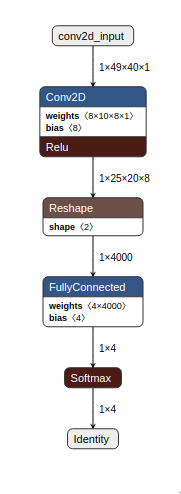

As mentioned earlier, any model to be run on an MCU should have a sufficiently small peak memory usage. During the execution, the runtime only has to store tensors for the input and the output of an operator (layer) that it's currently executing. (However, [things can get more complicated for models with branches](https://arxiv.org/abs/1910.05110), like the Inception family.)

We provide you with the `tflite-tools` toolkit to measure the peak memory usage.

In [ ]:
!pip install flatbuffers prettytable
!git clone https://github.com/eliberis/tflite-tools.git tflite_tools

Cloning into 'tflite_tools'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 314 (delta 259), reused 284 (delta 236), pack-reused 0
Receiving objects: 100% (314/314), 158.38 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (259/259), done.


In [ ]:
!python tflite_tools/tflite_tools.py -i model.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+----+----------------------------------------------------------------------------------+-----------------+-----------------+
| Id |                                      Tensor                                      |      Shape      | Size in RAM (B) |
+----+----------------------------------------------------------------------------------+-----------------+-----------------+
|  0 |                          serving_default_conv2d_input:0                          |  (1, 49, 25, 1) |           1,225 |
|  6 | sequential/conv2d/Relu;sequential/conv...equential/conv2d/BiasAdd/ReadVariableOp | (1, 25, 13, 16) |           5,200 |
|  7 |                            sequential/flatten/Reshape                            |    (1, 5200)    |           5,200 |
|  8 |                 sequential/dense/MatMul;sequential/dense/BiasAdd                 |      (1, 4)     |               4 |
|  9 |                            StatefulPartitionedCall:0                    

**For deployment to the micro:bit, keep the peak memory usage value reported here below ~64 KB and the model size below ~120 KB**.

We can check if the quantisation affected the performance of our model (compare this with the accuracy measurement of the testing dataset we did earlier).

In [ ]:
import numpy as np
from tqdm import tqdm

def evaluate(model_file, dataset):
    # Load the quantised TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()
    input_info = interpreter.get_input_details()[0]
    input_index = input_info["index"]
    scale, offset = input_info["quantization"]
    assert 0.10 <= scale <= 0.11 and offset == -128

    output_index = interpreter.get_output_details()[0]["index"]

    # Push the dataset through the model and compute accuracy
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    test_data = dataset.batch(1).as_numpy_iterator()

    for x, y_true in tqdm(test_data, total=len(dataset)):
        # The model expects a quantised input, spanning the entire range of int8
        x = (x / scale - offset).astype(np.int8)
        interpreter.set_tensor(input_index, x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_index)
        accuracy.update_state(y_true, y_pred)
    return accuracy.result()

accuracy = evaluate("model.tflite", dataset.testing_dataset())
print(f"accuracy (quantised model) = {accuracy:.4f}")

100%|██████████| 990/990 [00:05<00:00, 183.18it/s]


accuracy (quantised model) = 0.8990


### Model export

The following will export the model into a binary blob and also display its size.
You'll need to ensure it fits within the memory, otherwise you'll get an error: please refer to the Troubleshooting section below if it happens.

In [ ]:
# !apt-get update  # <-- run this if you get install errors
!apt-get -qq install xxd
!echo "Exporting model. Model size (in bytes):"
!stat --printf="%s" model.tflite
!xxd -i model.tflite > model.txt # xxd is just used to create a hex dump from model file

Exporting model. Model size (in bytes):
24920

In [ ]:
!cat model.txt

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x84, 0x58, 0x00, 0x00,
  0x94, 0x58, 0x00, 0x00, 0xbc, 0x60, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xb2, 0xa6, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x00, 0x00, 0x61, 0x63, 0x74, 0x69,
  0x76, 0x61, 0x74, 0x69, 0x6f, 0x6e, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x66, 0xa7, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0x0

Optionally, take a look at the contents of the blob. Download the `model.txt` file to your computer. Click the file icon on the left menu of this web to view all the downloaded and generated files on Google Colab Server. Right click to download the `model.txt`.

# Running the model on an MCU

## Installing the development software on your computer

The following assumes you will be using Mac OS or Linux as your operating system. If you're using Windows, you may need to do some extra work to adapt the instructions to your environment.

To prepare your machine for development, install [Docker or Docker Desktop](https://www.docker.com/products/docker-desktop).

If you prefer to use your current / host operating system to compile the software for a microcontroller, you can follow environment installation instructions in this [micro:bit samples repository](https://github.com/lancaster-university/microbit-v2-samples).

## Setting up the audio recognition project

Using the command line in your local machine, clone the project files:

`git clone https://github.com/eliberis/microbit-speech kws_model`

and navigate into the project directory:

`cd kws_model`

Compile the software through Docker:

`DOCKER_BUILDKIT=1 docker build -t microbit-tools --output out .`

Once that has finished, copy over the resulting binary to the microcontroller (this will "flash" it):

`cp out/MICROBIT.hex /Volumes/MICROBIT`

where `/Volumes/MICROBIT` is the location of the connected micro:bit, which will be recognised as a USB storage device.

Afterwards you can see what the board outputs into the terminal over the serial port by typing:

`screen /dev/tty.usbm<device_id> 115200` (or `/dev/ttyACM<device_id>` on Linux). You can use autocomplete to figure out the device ID under which the micro:bit appears on your system this time.

(use `Ctrl+A` then `Ctrl+D` to exit from `screen`)

You can now modify files in the `kws_model` directory and compile and flash them onto the board using the commands above.

## Using the keyword recognition model

The software running on the board listens for microphone input, then runs the keyword recognition model and prints its detections over the serial port (into the terminal). The recording stage is indicated by the red microphone LED lighting up, and lasts just over 1 second.

To restart the board and start a new round of keyword recognition, press the 'RESET' button on the back of the micro:bit. If your board only outputs "silence", try speaking louder or closer to the microphone.

Try the provided model before swapping in your own. The default model is not very good --- it's your task to improve it!

## Swapping in a new model

Previously, we went through an entire model creation pipeline that produced a binary blob into the `model.txt` file with the contents of our model. To swap the default model with your new one, follow these steps:

1. Open the `model_data.cpp` file from the `kws_model` folder and the downloaded `model.txt` file in your text editor.
2. Delete the contents of the `g_model_data` array in `model_data.cpp`.
3. Copy the contents of the model array from the `model.txt` file and paste them into the now-empty `g_model_data` array. Make sure preserve the type of the `g_model_data` array: it should still say `const unsigned char g_model_data[] DATA_ALIGN_ATTRIBUTE = { ...`
4. Update `g_model_data_len` value at the bottom of `model_data.cc` with the length value you see at the bottom of the `model.txt` file. Again, make sure to preserve the type.
5. If you changed the number of outputs in the model by changing the word list:
  * update the category count in the `model_settings.h` file; it should be the number of words your model will recognise, plus 2.
  * update category labels in the `model_settings.cpp` file: add strings for the new words you've added.
6. If you used a type of layer that this practical hasn't used so far and you get operation registration errors when trying to run your model, open the `audio_inference.cc` file and find the line that creates `tflite::MicroOpResolver<N>`. This pulls operator implementations into the software (at the cost of extra space, up to 2KB per operator). Follow the example there of how other layers were added and add a layer that you're missing (assuming it is available in TFLM). Change the `N` to the number of layers you're now registering. (You can also sacrifice a lot of space and pull in all layers by deleting lines relating to `micro_op_resolver` and changing the resolver type to `AllOpsResolver`.)

## Troubleshooting

* Compile/linker error `ld: region FLASH overflowed by XXXXX bytes`.

> Your model is too big! In the current version of software, you have approx. 139 KB left for your model, which includes both weights and architecture description. Keep the size (the number you paste into `model_data.cc`) under this threshold.

* `Arena size is too small` error / execution crashes / memory corruption.

> Your model's peak memory usage is too big for the micro:bit. Identify the peak using the `tflite_tools.py` code cell and reduce it. By default the tensor arena is set to 80 KB, but because of the framework overheads and inefficiencies, please keep your model peak memory usage under 64 KB.

> You can also reduce the input size by reducing `feature_bin_count` and `kFeatureSliceSize` parameters in both this notebook and microcontroller code, respectively.

* micro:bit flashes `030 :(`.

> Program execution stack corrupted the heap. Increase 'DEVICE_STACK_SIZE' in `codal.json`. If it doesn't help, refer to the previous point.

* micro:bit flashes `020 :(`.

> Your model execution is too complex. Decrease `kTensorArenaSize` in `main.cpp`: you may encounter one of the errors above, too.

* docker desktop installation `No space left on this device`.

> This refers to main memory instead of disk memory. Close some of your running application and re-launch docker desktop.

* docker on MacOS build error: request returned bad gateway for api route, check if the server supports the requested api version

> Close Docker Desktop, run the following commands:
```
rm -rf Library/Group\ Containers/group.com.docker
rm -rf Library/Containers/com.docker.docker
rm -rf Library/Application\ Support/Docker\ Desktop
```
Then restart your Docker Deskop

You can also enable debug output by setting `DMESG_SERIAL_DEBUG` and `CODAL_DEBUG` to 1 in the `codal.json` file.

# Tasks

The tasks and questions in the practicals for this course are split into two groups: A and B, with the first question applicable to both. We would like you to attempt tasks in just **one** of the groups. Feel free to attempt advanced questions, or do both groups if you find yourself enjoying the material!

* Group A: playing with neural network design to subsequent compression for a larger keyword classification problem; does not require deploying a model to an MCU, so you don't need to satisfy the model size and peak memory usage constraints.

* Group B: creating a suitably small model and deploying it to the micro:bit to recognise words of your choice.

**A1/B1.** Add one or more extra words when creating the `SpeechCommands` dataset and re-run the model training code above.
* What percentages for `silence` and `unknown` classes should you pick to obtain a balanced dataset* overall? _(*balanced s.t. these 2 classes occupy a proportionate fraction with the respect to word classes; this does not guarantee that the word classes will be balanced with respect to each other: e.g. "yes" may contain more samples than "no"; this proportion also does not guarantee the best performance at spotting keywords in practice on your hardware)_.

* Does the accuracy of the model change depending on the words (and the number of words) you choose to include? If so, what do you think could be the factors influencing the change?

### Group A



**A2.** Create a larger model that recognises the following words:

`['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']`

You may also want to adjust the optimiser, learning rate, or use a different convolutional kernel sizes and strides for the time and frequency axes of the input. Feel free to experiment with batch normalisation, residual connections, and other common neural network architecture patterns. Aim for 90%+ validation accuracy.

Present your developed model, including its classification accuracy and its size (check `model.summary()`).

**A3.** Design a similar compressed model through one of the following:

* replace some of the deeper convolutional layers (if your model has any) with [depthwise-separable convolutions](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D) (maybe followed by 1x1 convolutions),
* distilling it into a smaller model,
* implementing and using the [Octave Convolution](https://arxiv.org/abs/1904.05049),
* or use any other model compression method or implement another efficient neural architecture / layer arrangement / feature extraction block.

You do not need to convert your model into TensorFlow Lite format or deploy it to the micro:bit.

Do you expect your newly implemented model to become faster or smaller (or both?) as a result of your changes? Discuss.

*Rough guidance for distillation:* Come up with a smaller student network. Train the larger teacher model and freeze it using `teacher_model.trainable = False`. Create a smaller student network. Now, create a new combined Keras model that calls both the teacher and the student (in parallel) on the same input and outputs the output of the student network. Add an auxiliary cross-entropy or KL-divergence loss between the teacher and student models' outputs (`teaching_loss`) that will work in addition to the regular dataset loss (for example using the `tf.keras.losses.CategoricalCrossentropy()` class and `combined_model.add_loss(teaching_loss, inputs=True)`. Also, feel free to look up how to implement distillation in Keras (or just bare TensorFlow) online, but bear in mind that some examples might be outdated.

*Rough guidance for octave convolution:* Implement it either [as a custom layer](https://www.tensorflow.org/guide/keras/custom_layers_and_models) and/or explicitly define the two paths using [the functional API](https://www.tensorflow.org/guide/keras/functional). Note: you may struggle to convert this to TFLite, because 2D-upsampling is not supported by default.

*Pointers to other architectures*: Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration or other papers that cite it.

*Note on other frameworks*: If you prefer, you can use another deep learning framework. You may find it useful to reuse the data input pipeline: use `for image_batch, labels in train_data.as_numpy_iterator()` to iterate through an epoch of data.


**A4.** Design at least two compressed models using different compression techniques listed in A3 (For example, one model uses distilling, the other one uses octave convolution). Compare their accuracy, model size, and operations counts (Multiply-Add operations). List the advantages and disadvantages of the compression techniques you are comparing.

### Answer A1:
#### Using 10% unknown and 10% silence
> Only using the classes ["yes", "no", "unknown", "silence"] gives an accuracy of 90.51%
>
>Adding the word 'Marvin' drops the accuracy by around 3% to 87.33%
>
> Adding the word 'zero' drops the accuracy by a little less than 3% to 87.87%
>
>
>> => Thus, I would say that the words we choose make a difference, but not too much since the dataset is most likely balanced to a certain degree. The factor that does influence the accuracy might be how similar the representation of a word is to another selected word. If they have similar patterns the accuracy might be more negatively affected than when choosing very different words.

---

#### Using 25% unknown and 25% silence
> Only using the classes ["yes", "no", "unknown", "silence"] gives an accuracy of 86.97% when using 25% for unknown and silence.
>
>> => Increasing the value of unknown and silence to 25% did not improve results. So balancing the data set completely does not seem to be perfect either.

---

#### Using 4% for unknown and 4% silence
> Only using the classes ["yes", "no", "unknown", "silence"] gives an accuracy of 93.26% when using 4% for unknown and silence.

---

#### Using 3% for unknown and 3% silence
> Only using the classes ["yes", "no", "unknown", "silence"] gives an accuracy of 92.79% when using 3% for unknown and silence.

---
---

#### Evaluation
From these results, it becomes evident that the percentages for silence and unknown are not very aligned with the number of classes.

### Answer A2

For question A2, I have decided to go for a model with residual connections and batch normalization layers, as suggested in the question prompt. I first tried to increase the number of layers, use batch normalization, and larger filters. However, that only got me to roughly 90% and not beyond that while having a model size of over 5 MB. Therefore, I decided to redo this answer and find a better solution. The following is what I came up with.

I copied the setup code from above so that I would not have to scroll so much :)

In [ ]:
# Only need to run this cell once per machine you get allocated (i.e. when your files get lost).
# No need to re-run between different runtime refreshes.
# !pip uninstall -y tensorflow tensorflow-gpu tensorflow-estimator tensorboard keras
# !pip install tensorflow-gpu==2.7.0
!curl https://raw.githubusercontent.com/eliberis/microbit-speech/main/speech_dataset.py > speech_dataset.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23632  100 23632    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k


I should have probably lowered the percentages for silence and unknown more.

In [ ]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

from speech_dataset import SpeechDataset
dataset = SpeechDataset(words=['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes'],
                        upper_band_limit=5000.0,  # ~ human voice range
                        lower_band_limit=125.0,
                        feature_bin_count=25,
                        window_size_ms=40.0,
                        window_stride=20.0,
                        silence_percentage=5, unknown_percentage=5)
batch_size = 128
train_data = dataset.training_dataset().batch(batch_size).prefetch(1) # .prefetch(1) preloads a batch onto a GPU
valid_data = dataset.validation_dataset().batch(batch_size).prefetch(1)

Using TensorFlow version 2.14.0
>> Downloading speech_commands_v0.02.tar.gz 100.0%

This is the residual block I am using. It consists of 2D convolutional layers, standard in an image recognition task. I also use batch normalization since it helps stabilize training. It should also act like a regularizer. However, I still decided to add Dropout() to help prevent overfitting. The activation layer using ReLu should help the model detect non-linear patterns in the data.

In [ ]:
import tensorflow as tf

def residual(x, filters, kernel_size=3, strides=1, activation="relu"):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Activation(activation)(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
      shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="SAME")(shortcut)
      shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation(activation)(x)

    return x

In this function, we create the model by defining the first 2D convolutional layer, batch normalization, max pooling, and activations. The reasoning is similar to the setup of the residual connections. I also call the residual block three times with a filter size of 128 and stride length of 1. These values provided good results in my tests.

In [ ]:
def create_model(input_layer, num_classes):
    x = tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="SAME")(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="SAME")(x)


    x = residual(x, filters=128, strides=1)
    x = residual(x, filters=128, strides=1)
    x = residual(x, filters=128, strides=1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

For the compilation, I am using AdamW since it should avoid overfitting better than Adam. During training, I also use early stopping to prevent overfitting, although I give it a lot of patience to get good results, so it was not triggered in the end.

Also, notice how surprisingly large the model is, with 4.58 MB in total parameter size. I will fix this in the following two answers when I compress the model.

In [ ]:
input_shape = dataset.sample_shape()
num_classes = dataset.label_count()
input_layer = tf.keras.layers.Input(shape=input_shape)

model = create_model(input_layer=input_layer, num_classes=num_classes)

model.summary()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_data, validation_data=valid_data, epochs=28, callbacks=[early_stopping])

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 49, 25, 1)]          0         []                            
                                                                                                  
 conv2d_93 (Conv2D)          (None, 25, 13, 64)           1088      ['input_17[0][0]']            
                                                                                                  
 batch_normalization_93 (Ba  (None, 25, 13, 64)           256       ['conv2d_93[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_83 (Activation)  (None, 25, 13, 64)           0         ['batch_normalization_9

Saving the trained model since I want to reuse the model in the following steps without having to retrain every time I restart the session.

In [ ]:
model.save("model-uncompressedRes.h5")

In the next block, I evaluate the model against the test data.

In [ ]:
test_data = dataset.testing_dataset().batch(64)
model = tf.keras.models.load_model("model-uncompressedRes.h5");
model.evaluate(test_data)

71/71 [==============================] - 8s 20ms/step - loss: 0.3165 - accuracy: 0.9181


[0.3164973855018616, 0.9181169271469116]

The accuracy is now above 91.81%!!

### Answer A3

The first compression technique I chose is distillation. For this, I used the distiller class provided by [Keras](https://keras.io/examples/vision/knowledge_distillation/).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

For the student, I took some inspiration from the Keras example I mentioned above. However, some rather significant changes are needed to get the student close to the teacher regarding accuracy. So, I added more layers and increased the number of filters, which did the trick.

In [ ]:
#Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(49, 25, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Flatten(),
        layers.Dense(12, activation='softmax'),
    ],
    name="student",
)


# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

Here, I distill the teacher to the student model. The distillation is not suddenly much faster than the previous training. The epoch times got shorter because I had to buy GPU time. I kept getting timed out, and my hardware is not good enough to train models on :/.

From the student summary, we see that the model size is significantly reduced from almost 5 MB down to 304.3 KB.

In [ ]:
# Initialize and compile distiller

distiller = Distiller(student=student, teacher=model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
student.summary()
distiller.fit(train_data, epochs=35)

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 49, 25, 32)        320       
                                                                 
 batch_normalization_7 (Bat  (None, 49, 25, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 49, 25, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 25, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 13, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 25, 13, 64)        256 

I trained the model for 35 epochs since I noticed that distillation requires more epochs than training the teacher. I think more epochs could improve the result even more, but I wanted to avoid overfitting.

In [ ]:
test_data = dataset.testing_dataset().batch(64)
distiller.evaluate(test_data)

71/71 [==============================] - 2s 19ms/step - accuracy: 0.9005 - student_loss: 0.3343


[0.9004908800125122, 0.17021968960762024]

After 35 epochs, I got an accuracy of 90.05%, which is excellent and close to the uncompressed model, which achieved 91.88%. Please note that the distilled student is only a fraction of the teacher's size but retains similar accuracy.

The compressed model is, as expected, a lot smaller than the teacher. I would suspect that the inference speed is faster with the compressed model since we reduced the number of parameters. The smaller size of the model will also reduce loading times. This is especially good for edge devices with limited memory, which forces more frequent loads.

### Answer A4:
For the second compression method, I chose depthwise convolutions and the residual connection approach from A2.

After some trial and error, I reduced the number of filters, turned the deeper convolutional layers into depthwise convolutional layers, added additional depthwise layers, and removed some of the layers that had little effect.

In [ ]:
import tensorflow as tf

def residual(x, filters, kernel_size=3, strides=1, activation="relu"):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size, strides=strides, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=1, strides=strides, padding="SAME")(x)

    if strides != 1 or shortcut.shape[-1] != filters:
      shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="SAME")(shortcut)
      shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation(activation)(x)

    return x

In [ ]:
def create_model(input_layer, num_classes):
    x = tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="SAME")(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)

    x = residual(x, filters=64, strides=1)
    x = residual(x, filters=64, strides=1)
    x = residual(x, filters=64, strides=1)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, padding="SAME")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=1, strides=1, padding="SAME")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

This approach was a lot more work than A2, where I did not care about the size, but it added some extra fun :). Overall, I reduced the size of the model to 394.67 KB.

In [ ]:
input_shape = dataset.sample_shape()
num_classes = dataset.label_count()
input_layer = tf.keras.layers.Input(shape=input_shape)

model = create_model(input_layer=input_layer, num_classes=num_classes)

model.summary()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_data, validation_data=valid_data, epochs=35, callbacks=[early_stopping])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 49, 25, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 13, 32)           544       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 13, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 13, 64)           18496     ['batch_normalization[0][0

Early stopping interrupted training after 19 epochs.

I am saving the model so I do not need to train the model again if I need it in the future.

In [ ]:
model.save("model-dephtwise.keras")

The compressed model still performs great, with an accuracy of 90.9%!

In [ ]:
test_data = dataset.testing_dataset().batch(64)
# model = tf.keras.models.load_model("model-dephtwise.keras");
model.evaluate(test_data)

71/71 [==============================] - 2s 23ms/step - loss: 0.3009 - accuracy: 0.9090


[0.30094921588897705, 0.9089692234992981]

### Comparing Depthwise Convolutional Layers with Distillation
Both approaches had great results in this test.

> The distilled model has a size of **304.30 KB** and achieves an accuracy of **90.05%**.
>
> The depthwise convolutional model has a size of **394.67 KB** and achieves an accuracy of **90.9%**

Overall, the results are very similar. The depthwise model gave us a slightly better accuracy at the cost of a larger model size. However, I think the distilled model could have reached that accuracy with more epochs. Ultimately, I think it is more important to consider how much GPU power you have available since a distilled model requires two rounds of training. First, the teacher needs to be trained, and then the student. If you already have a trained teacher model and now need a compressed model, distillation is an excellent choice. In the end, it comes down to the computing capabilities and the circumstances.

### Group B
**B2:** Play around with the architecture of the model and the training parameters. Aim for at least 5 words of your choice (informed by question B1). In your investigation, you may consider the following:

1. Using a fully-connected model (only `Flatten` and `Dense` layers, extra helpful layers like `BatchNormalization` and `Dropout` are also allowed).

2. A larger convolutional network than the one already given (e.g. try adding more `Conv2D` layers with different parameters and `BatchNormalization` layers between `Conv2D` and `Activation('relu')`).

3. Tuning the number of epochs, the optimizer and the learning rate at each epoch. Tip: You may find the [`tf.keras.callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback useful.

4. Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration.

Present **any three** neural networks that you've implemented as a part of your investigation. Make sure they fit within resource constraints of your device. What's the architecture of the network, the number of words it recognises, and its accuracy? Your models should be able to reach over 90% validation accuracy.

**B3.** Find a way measure the amount of time taken by the model, that is the time difference of before and after the `TfLiteStatus invoke_status = interpreter.Invoke();` line in `audio_inference.cc`.

**B4.** Compare the speed (using the method in B3), model size and operation counts (Multiply-Add operations) of the three models you develop.



You get to keep the BBC micro:bit---have fun with it and build something cool! Check out the [micro:bit website](https://www.microbit.org/) for inspiration, and the [C++ API](https://rneacy.dev/mbv2/).

Group B answers: (type in your answers here)

(c) 2022 Edgar Liberis. Licence CC BY 4.0. Material adapted from [TensorFlow Lite Micro speech example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/speech_commands) and TensorFlow tutorial on [post-training quantisation](https://www.tensorflow.org/lite/performance/post_training_quantization).

#### The Model I used before adding residual connections in question A2

In [ ]:
import tensorflow as tf

input_shape = dataset.sample_shape()
num_classes = dataset.label_count()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (10, 8), strides=(2, 2), padding="SAME", activation="relu", input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (9, 9), strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation("softmax")
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.004),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_data, validation_data=valid_data, epochs=28, callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 25, 13, 16)        1296      
                                                                 
 batch_normalization_20 (Ba  (None, 25, 13, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 13, 7, 128)        166016    
                                                                 
 batch_normalization_21 (Ba  (None, 13, 7, 128)        512       
 tchNormalization)                                               
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 4, 256)         819456    
                                                                 
 batch_normalization_22 (Ba  (None, 7, 4, 256)        

In [ ]:
model.save("model-uncompressed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_data = dataset.testing_dataset().batch(64)
model = tf.keras.models.load_model("model-uncompressed.h5");
model.evaluate(test_data)

71/71 [==============================] - 16s 111ms/step - loss: 0.3392 - accuracy: 0.9021


[0.3392104506492615, 0.902052640914917]